## Preprocessing

In [1]:
import json
import numpy as np
import pandas as pd
import gensim
import networkx as nx

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from num2words import num2words
from pprint import pprint
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import scipy.sparse as sp 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import seaborn as sns

# for Mac
%matplotlib inline
%config InlineBackend.figure_format='retina'

In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/martin/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

### Open dict

In [2]:
parsed_sites = 'abs_dict.json'

print("Started Reading JSON file")
with open(parsed_sites, "r") as read_file:
    abstract_dict = json.load(read_file)
    print("Decoded JSON Data From File")

Started Reading JSON file
Decoded JSON Data From File


In [3]:
abstract_df = pd.DataFrame.from_dict(abstract_dict)
abstract_df.head()

,doi,titles,abstracts,authors,keywords,sources
0,10.3390,Community Faecal Management Strategies and Per...,Most people in rural areas in South Africa (SA...,"[Matthew Mamera, Johan J. van Tol, Makhosazana...",agriculture,mdpi
1,10.3390,Adoption of Sustainable Agriculture Practices ...,The aim of this study was to highlight the imp...,"[Rafay Waseem, Gershom Endelani Mwalupaso, Far...",agriculture,mdpi
2,10.3390,Atlanta Residents’ Knowledge Regarding Heavy M...,Urban agriculture and gardening provide many h...,"[Lauren Balotin, Samantha Distler, Antoinette ...",agriculture,mdpi
3,10.3390,Perceptions of the Challenges and Opportunitie...,Waste management has become pertinent in urban...,"[Nqubeko Neville Menyuka, Melusi Sibanda, Urmi...",agriculture,mdpi
4,10.3390,An Assessment of Seaweed Extracts: Innovation ...,Plant growth regulators (PGRs) are described i...,"[El Chami Daniel, Galli Fabio]",agriculture,mdpi


In [4]:
keywords = abstract_df.groupby('keywords').count()
keywords.head(60)

,doi,titles,abstracts,authors,sources
keywords,,,,,
CNN,279,279,279,279,279
agric,21,21,21,21,21
agricultural technology,80,80,80,80,80
agriculture,227,227,227,227,227
agriculture CNN,215,215,215,215,215
agriculture computer vision,193,193,193,193,193
agriculture deep learning,35,35,35,35,35
agriculture machine learning,230,230,230,230,230
agriculture object recognition,211,211,211,211,211


### Build 3 corpus : ML, agriculture, mix

In [5]:
agri_labels = ["agronomy", "agriculture", "mildew", "wheat", "barley", "agric"]
ML_labels = ["CNN", "computer vision", "deep learning", "image segmentation", "machine learning", "neural networks", "object recognition", "supervised learning", "unsupervised learning"]

abstracts = abstract_dict['abstracts']
agri_abstracts = []
ML_abstracts = []
mix = []
for i in range (len(abstract_dict["abstracts"])):
    if abstract_dict["keywords"][i] in agri_labels:
        agri_abstracts.append(abstract_dict["abstracts"][i])
    elif abstract_dict["keywords"][i] in ML_labels:
        ML_abstracts.append(abstract_dict["abstracts"][i])
    else:
        mix.append(abstract_dict["abstracts"][i])

### Preprocess abtracts

In [6]:
# Useful functions

def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def lemming(data):
    lemmatizer = WordNetLemmatizer() 
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = lemming(data)
    return data


# Preprocessing
def preprocess_corpus(corpus,tokenize=True):
    preprocess_abstract = []
    for abstract in corpus:
        preprocess_abs = str(preprocess(abstract))
        if tokenize: preprocess_abstract.append(word_tokenize(preprocess_abs))
        else: preprocess_abstract.append(preprocess_abs)
    return preprocess_abstract

<>:7: DeprecationWarning: invalid escape sequence \]
<>:7: DeprecationWarning: invalid escape sequence \]
<>:7: DeprecationWarning: invalid escape sequence \]
<ipython-input-6-71bfbc015bb6>:7: DeprecationWarning: invalid escape sequence \]
  symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"


### Make bigrams

In [7]:
"""
# Build the bigram and trigram models
# Careful: it might be worth creating th bigrams etc before dtemming and lemming
bigram = gensim.models.Phrases(preprocess_abstract) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[preprocess_abstract], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
"""


def make_bigrams(preprocess_abstract,full_string=True):
    data_processed = []
    bigram = gensim.models.Phrases(preprocess_abstract)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    for abstract in preprocess_abstract:
        data_processed.append(bigram_mod[abstract])
        
    if full_string:
        for i in range (len(data_processed)):
            inter = ""
            for j in range (len(data_processed[i])):
                inter+=" " + data_processed[i][j]
            data_processed[i]=inter
        
    return data_processed

### Main preprocess

In [8]:
preprocess_abstract = preprocess_corpus(mix)
bigrams = make_bigrams(preprocess_abstract)

### Vocabulary of the corpus

In [10]:
vocabulary = FreqDist()
for s in preprocess_abstract:
    vocabulary.update(s)
print(vocabulary)

<FreqDist with 15475 samples and 301406 outcomes>


## TF-IDF on Mix Corpus

In [230]:
# calling the TfidfVectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(bigrams)
feature_names = vectorizer.get_feature_names()  

### TF-IDF sum scores

In [49]:
# here we are calculating the tf idf score (fitting it specifically in each bstract)
# and then summing the tf-idf scores on all the texts

words = {}
for i in range (len(bigrams)):
    response = vectorizer.transform([bigrams[i]])
    feature_names = vectorizer.get_feature_names()

    for col in response.nonzero()[1]:
        if feature_names[col] not in words.keys():
            words[feature_names[col]] = response[0, col]
        else:
            words[feature_names[col]] += response[0, col]
                     
# Retrieving the words with highest sum of tf idf scores (not very pertinent)
nbr_words = 50

words_copy = words.copy()
words_copy.pop("use")
words_copy.pop("two")
words_copy.pop("one")
words_copy.pop("data")


max_words = []

for i in range (nbr_words):
    maximum = max(words_copy, key=words_copy.get)  
    max_words.append(maximum)
    words_copy.pop(maximum) 

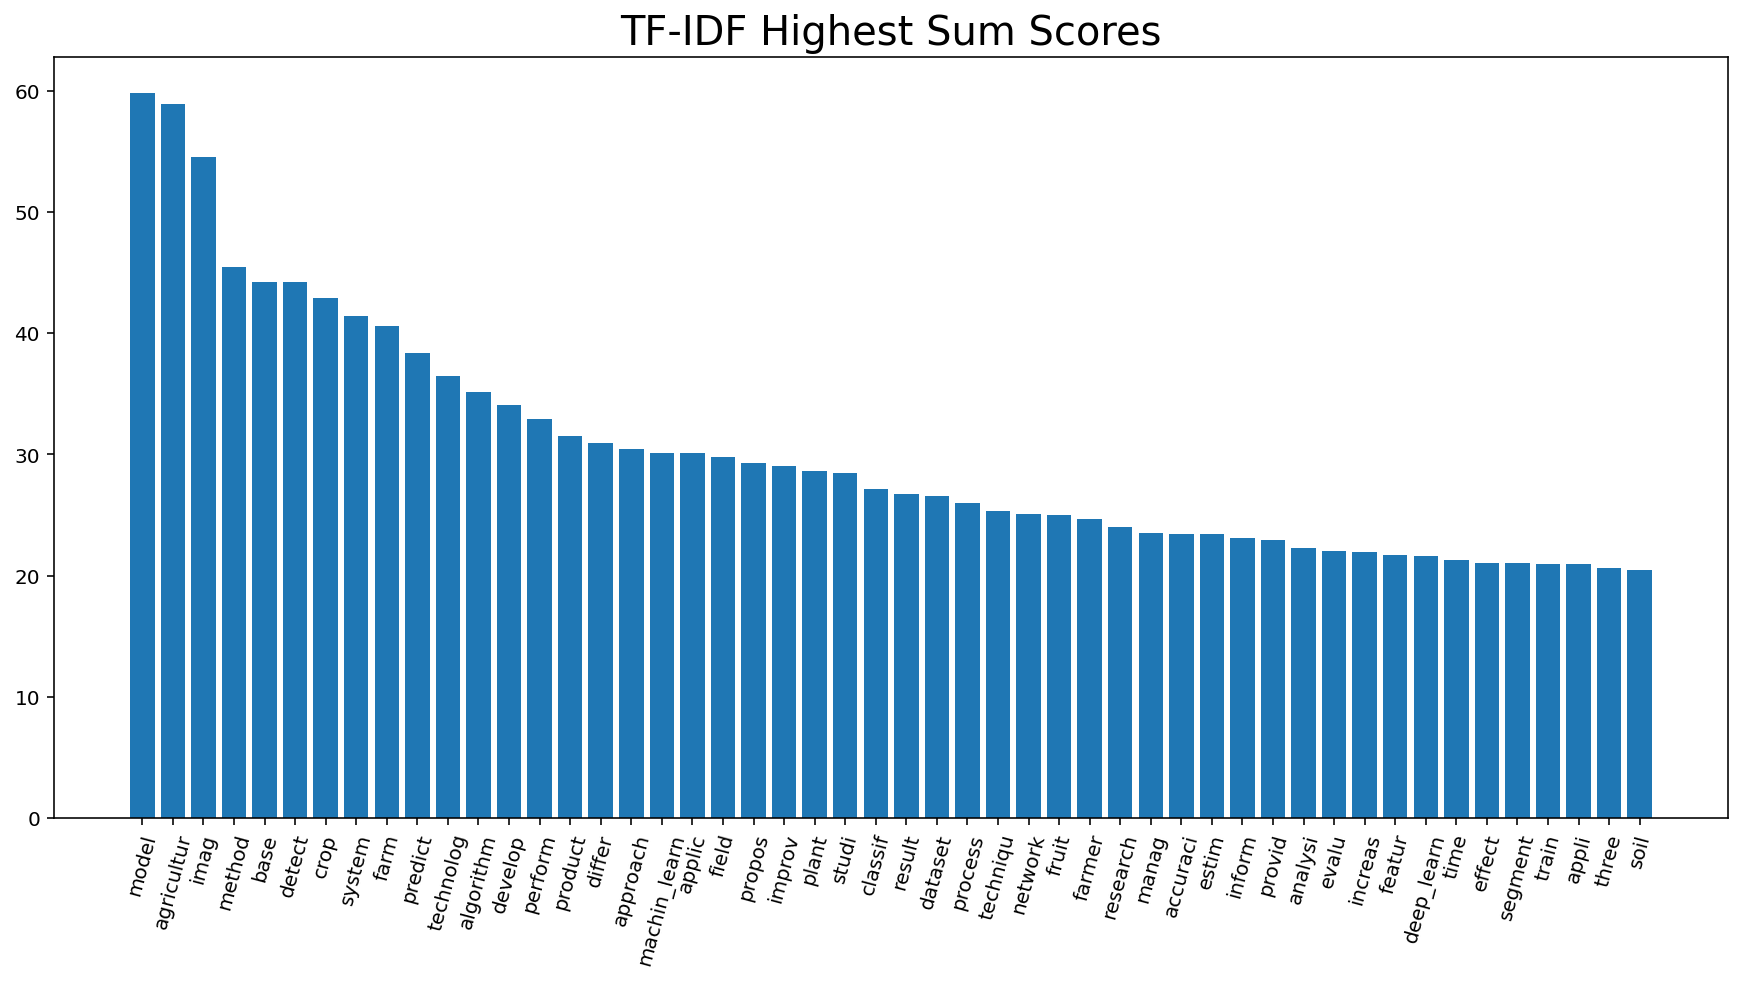

In [87]:
f, ax = plt.subplots(1,1,figsize=(15,7))
sum_score = [words[word] for word in max_words]
ax.set_title("TF-IDF Highest Sum Scores",fontsize=20)
ax.bar(max_words,sum_score)
plt.xticks(rotation=75)
plt.show()

### TF-IDF highest scores

In [9]:
# Create lists with score for each word
def top_n_tfidf_feats(X,features,nbr_words):
    words = []
    scores = []
    for doc in range (X.shape[0]):
        feature_index = X[doc,:].nonzero()[1]
        tfidf_scores = zip(feature_index, [X[doc, x] for x in feature_index])
        for w, s in [(features[i], s) for (i, s) in tfidf_scores]:
            words.append(w)
            scores.append(s)


    # Order and retrieve words with score        
    best_words = []
    for i in range (nbr_words):
        index = scores.index(max(scores))
        if words[index] not in best_words:
            best_words.append(words[index])
        del(words[index])
        del(scores[index])

    return best_words

In [51]:
best_words = top_n_tfidf_feats(matrix,feature_names,25)
print(best_words)

['intern_audienc', 'co', 'avail_item', 'graphic', 'roof', 'compost', 'meso_institut', 'wetland', 'dark_spot', 'mangrov_forest', 'sea_cucumb', 'hlb', 'lane_mark', 'lwd_model', 'sheep', 'plant_factori', 'compress']


In [10]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

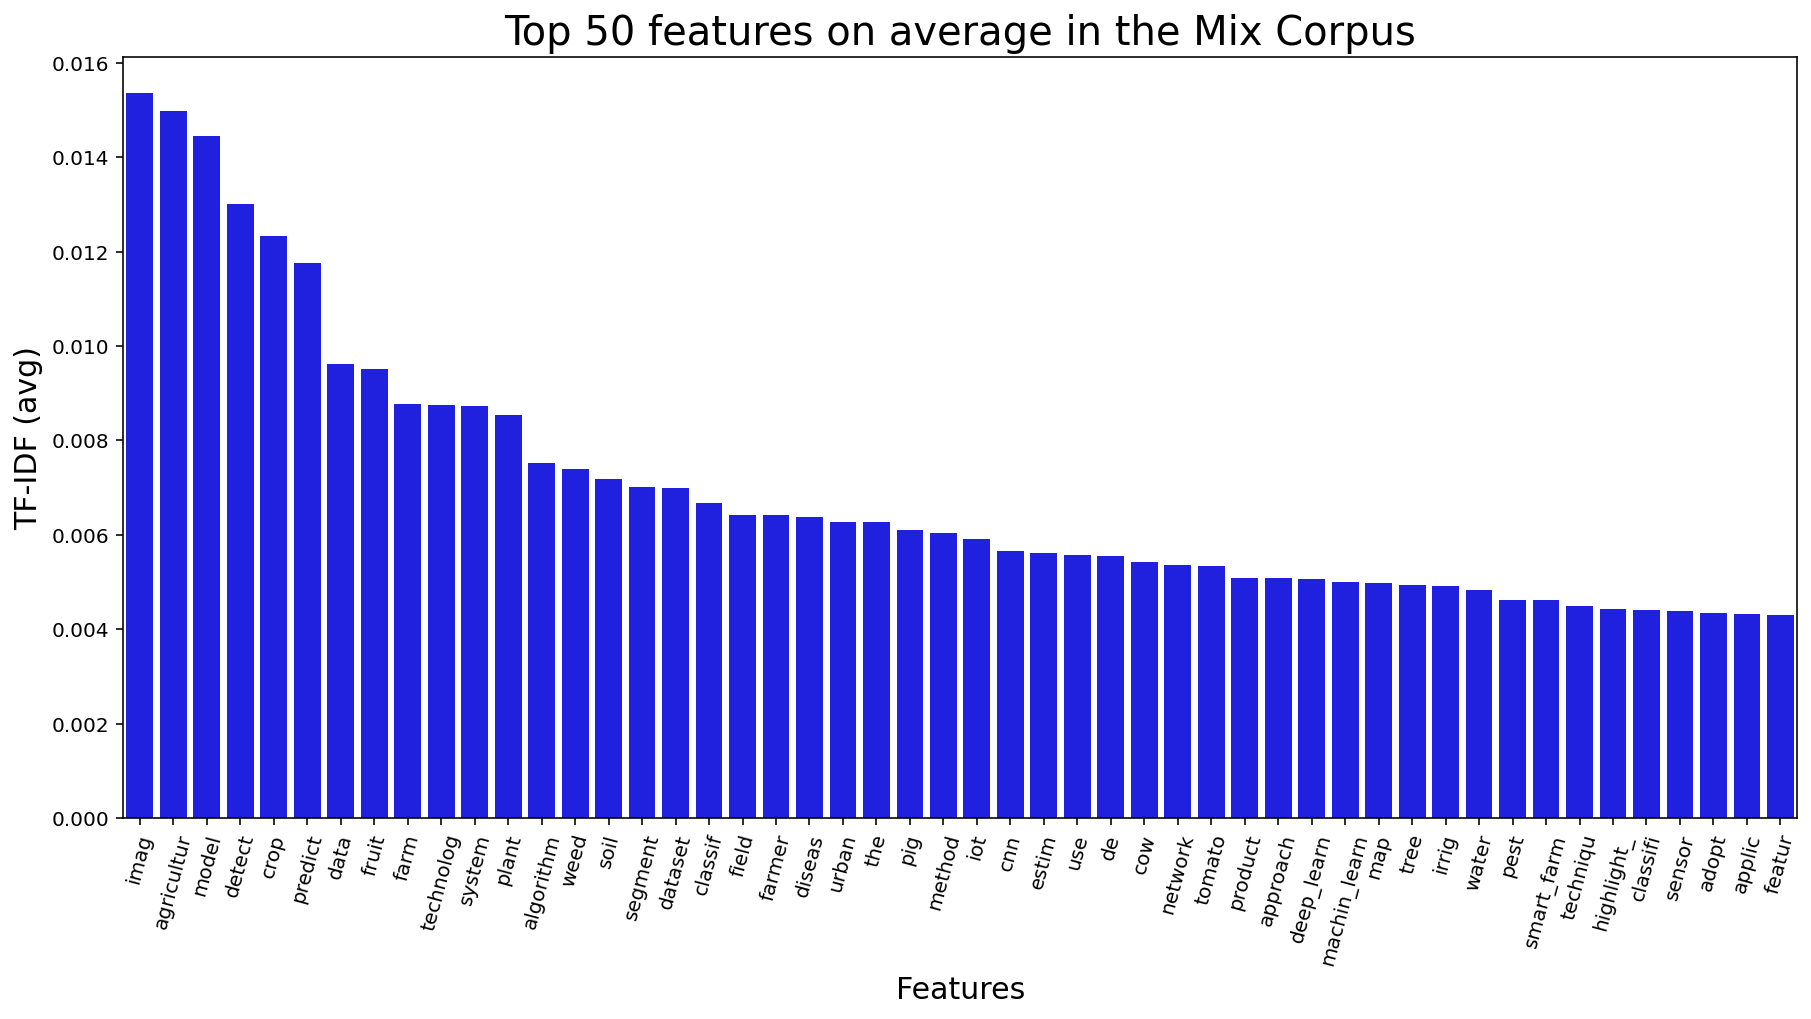

In [100]:
top_words = top_mean_feats(matrix,feature_names,top_n=50)

f, ax = plt.subplots(1,1,figsize=(15,7))
sns.barplot(data=top_words, x="feature", y="tfidf", color="blue",ax=ax)
ax.set_title("Top {} features on average in the Mix Corpus".format(len(top_words.feature)),fontsize=20)
ax.set_xlabel("Features",fontsize=15)
ax.set_ylabel("TF-IDF (avg)",fontsize=15)
plt.xticks(rotation=75)
plt.show()

### Co-occurences

In [12]:
def co_occurence(max_words, corpus):
    matrix_dict = {}
    matrix = np.zeros((len(max_words), len(max_words)))
    for i in range (len(max_words)-1):
        for j in range (i+1, len(max_words)):
            matrix_dict[max_words[i]+" "+max_words[j]] = 0
            for abstract in corpus:
                if (max_words[i] in abstract) and (max_words[j] in abstract):
                    matrix[i,j]+=1
                    matrix[j,i]+=1
                    matrix_dict[max_words[i]+" "+max_words[j]] +=1
                    
    return matrix, matrix_dict

In [86]:
copy = dic.copy()

d = {}
for i in range (nbr_bigrams):
    maximum = max(copy, key=copy.get)
    print(maximum)
    d[maximum] = copy[maximum]
    copy.pop(maximum)

agricultur product
model use
imag use
agricultur use
data use
method use
model predict
detect use
farm use
system use
agricultur technolog
predict use
crop use
agricultur farm
algorithm use
imag detect
imag method
use product
model data
model method
technolog use
agricultur crop
use approach
farm product
use machin_learn
agricultur method
detect method
field use
agricultur system
imag model
agricultur model
classif use
model machin_learn
use applic
predict data
imag algorithm
agricultur data
plant use
data farm
imag agricultur
technolog product
data method
imag dataset
model algorithm
agricultur field
use techniqu
dataset use
crop product
farmer use
estim use
use featur
data machin_learn
model crop
model system
method product
agricultur farmer
model approach
farm system
model detect
farm farmer
data system
use network
imag system
agricultur applic
detect algorithm
imag classif
use classifi
crop data
imag segment
fruit use
detect fruit
segment use
algorithm method
predict method
model f

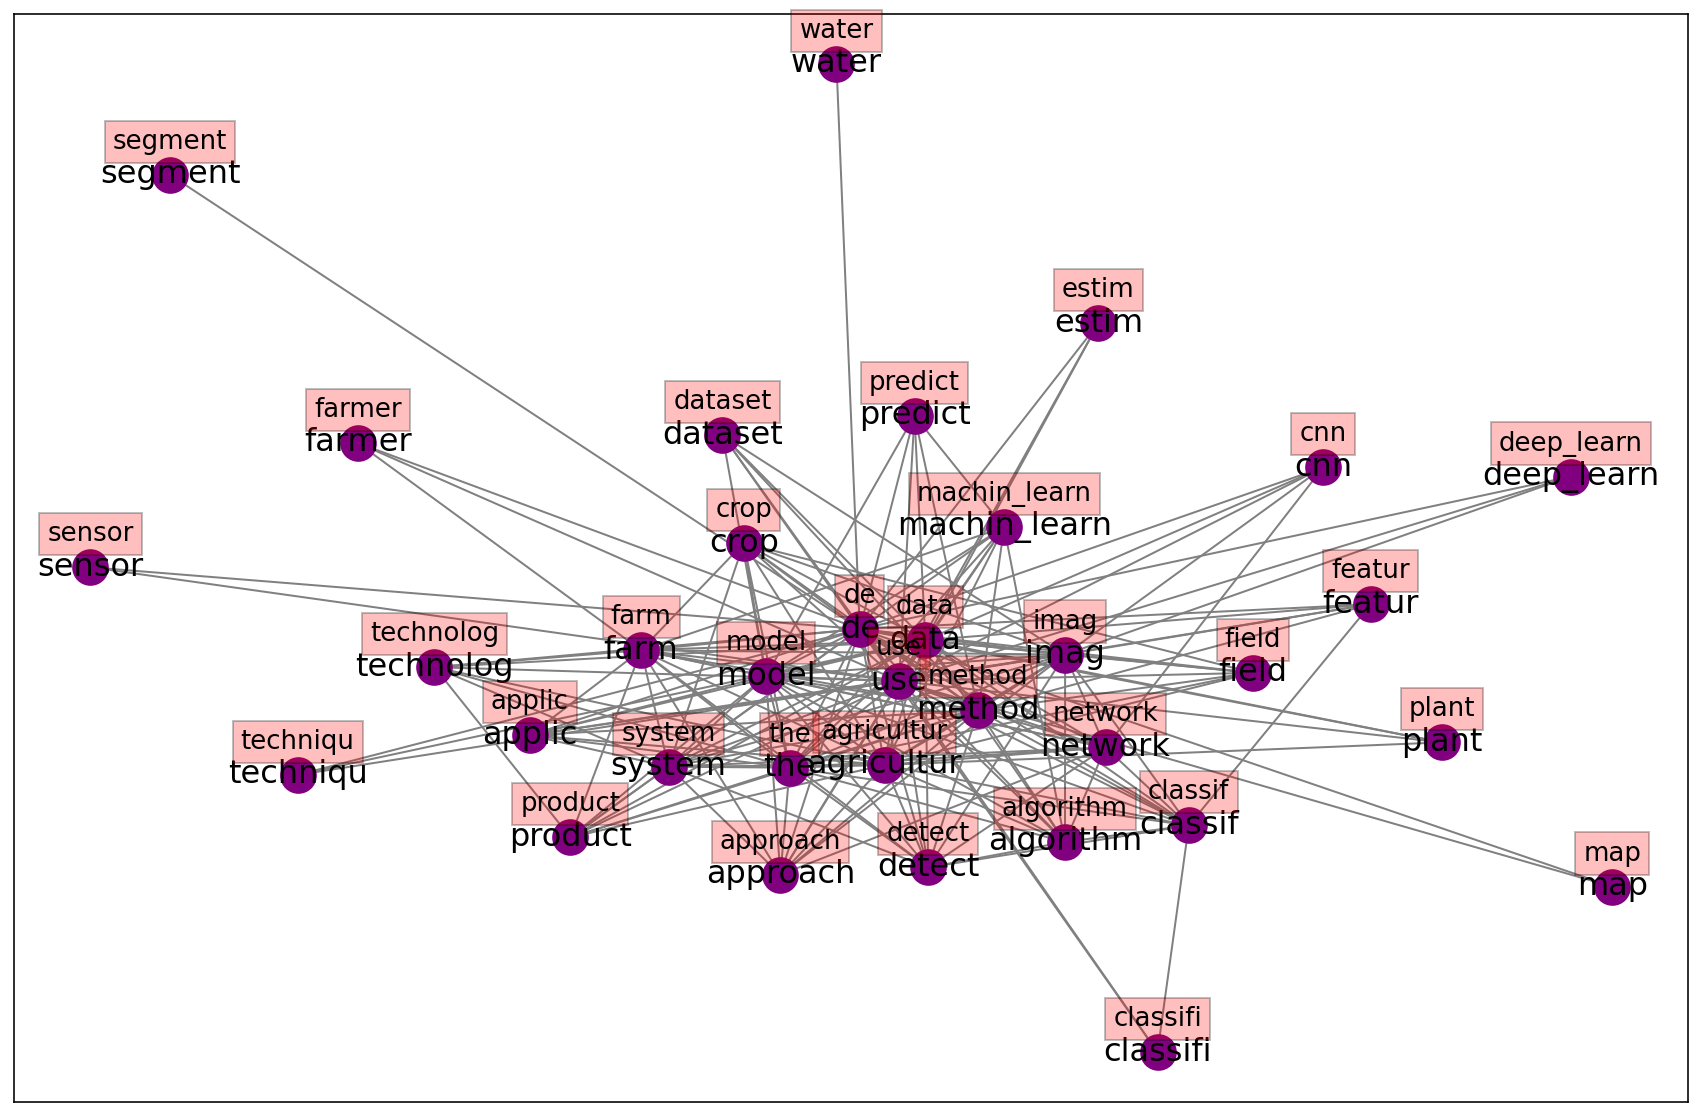

In [82]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d.items():
    k=k.split(" ")
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(15, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0], value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


In [ ]:
# New method

In [246]:
def fill_dict(matrix,voc):
    dict_voc = {}
    for i in range(len(voc)):
        for j in range (i+1, len(voc)):
            co = voc[i] +" "+ voc[j]
            dict_voc[co]=matrix[i,j]
    return dict_voc

def cooccurence_wdict(corpus,voc,bigram=True):
    count_vectorizer = CountVectorizer(vocabulary=voc)
    
    if bigram:
        bigrams_cooc = make_bigrams(corpus,full_string=True)
        Xc = count_vectorizer.fit_transform(bigrams_cooc)
    else:
        Xc = count_vectorizer.fit_transform(corpus)
        
    Xc = (Xc.T * Xc)
    Xc.setdiag(0)

    Xc = Xc.todense()
    
    return Xc, fill_dict(Xc,voc)

def highest_cooc(co_dict,n):
    dict_ = matrix_dict.copy()

    d = {}
    for i in range (n):
        maximum = max(dict_, key=dict_.get)
        d[maximum] = dict_[maximum]
        dict_.pop(maximum)
    return d

In [233]:
cooc_matrix, cooc_dict = cooccurence_wdict(preprocess_abstract,top_words.feature)

In [234]:
cooc_matrix

matrix([[   0, 1522, 1701, ...,  210,  848,  928],
        [1522,    0, 1701, ...,  472, 1181,  344],
        [1701, 1701,    0, ...,  285,  958,  771],
        ...,
        [ 210,  472,  285, ...,    0,   78,   42],
        [ 848, 1181,  958, ...,   78,    0,  202],
        [ 928,  344,  771, ...,   42,  202,    0]])

In [240]:
dict_top_cooc = highest_cooc(cooc_dict,50)

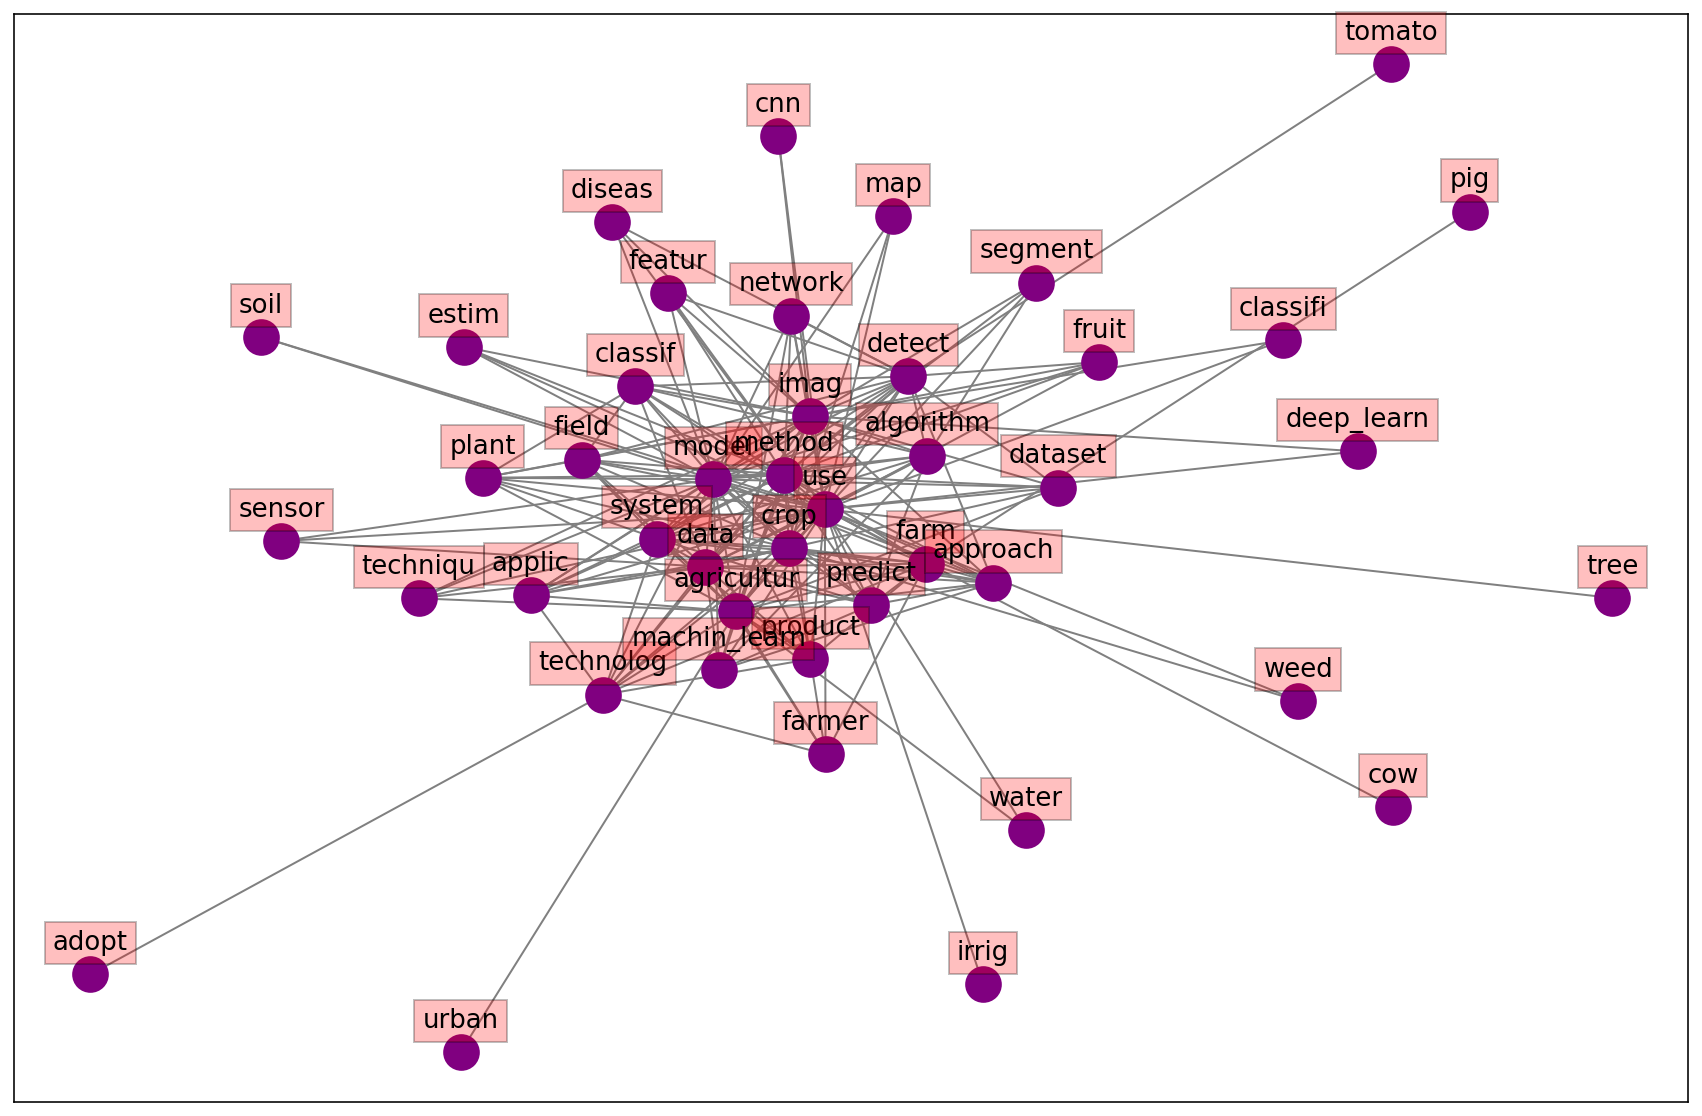

In [241]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d.items():
    k=k.split(" ")
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(15, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0], value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


In [88]:
co_matrix, matrix_dict = co_occurence(list(vocabulary.keys()), bigrams)

KeyboardInterrupt: 

## LDA - Topic Modeling

In [20]:

def remove_highest_freq(c, term_nbr):
    #removes terms of highest frequecies in the whole corpus
    #input: list of the form [["ajh", "ghkv"], [" "], ["poj", "poj", "ajh"]]
    #output: same list without the terms of highest frequencies
    a=[]
    for i in range (len(c)):
        a = np.concatenate((a,c[i]))
    counter=collections.Counter(a)
    indesirables = []
    for i in range (term_nbr):
        maximum = max(counter, key=counter.get)  # Just use 'min' instead of 'max' for minimum.
        indesirables.append(maximum)
        counter.pop(maximum)#print(maximum, mydict[maximum])
    for j in range(len(c)):    
        for elem in indesirables:
            c[j] = list(filter(lambda b: b != elem, c[j]))
    return c



def build_LDA(corpus):
    preprocess_abstract = preprocess_corpus(corpus)
    bigrams = make_bigrams(preprocess_abstract)

    for i in range (len(bigrams)):
        if bigrams[i][0]==" ":
            bigrams[i] = bigrams[i][1:]
        bigrams[i] = bigrams[i].split(" ")
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(bigrams)

    # Create Corpus
    texts = bigrams
    
    #remove p terms of highest frequency:
    texts = remove_highest_freq(texts, term_nbr=100)

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=20, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    """
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    """

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    return vis

In [21]:
build_LDA(agri_abstracts)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.358439  0.173607       1        1  24.084656
11    -0.372918  0.079834       2        1  23.830039
14    -0.338412 -0.046940       3        1  21.182258
9     -0.282144 -0.215911       4        1  14.960118
4     -0.105128 -0.182715       5        1   4.912349
7     -0.005441  0.228538       6        1   2.877646
19     0.075286  0.001847       7        1   1.472293
12     0.103683  0.008088       8        1   1.378389
3      0.095552  0.005923       9        1   1.113101
0      0.077132 -0.043652      10        1   1.092461
5      0.106225  0.001882      11        1   0.754751
17     0.112201  0.000478      12        1   0.582599
10     0.112518 -0.000610      13        1   0.432106
18     0.107455 -0.006690      14        1   0.368559
8      0.113101 -0.001608      15        1   0.289032
6      0.113446  0.000275      16        1   0.195462
15     0.111460 -0.000114      17        1   0.163674
16     0.111875 -0.000589      18        1   0.128238
2      0.111593 -0.000752      19        1   0.119676
13     0.110954 -0.000888      20        1   0.062594, topic_info=                Term       Freq       Total Category  logprob  loglift
253     two_thousand  433.00000  433.000000  Default   30.000  30.0000
959               de  282.00000  282.000000  Default   29.000  29.0000
1417           wheat  806.00000  806.000000  Default   28.000  28.0000
2740           grain  564.00000  564.000000  Default   27.000  27.0000
1639            gene  754.00000  754.000000  Default   26.000  26.0000
...              ...        ...         ...      ...      ...      ...
3031   drought_toler    0.00561    0.904521  Topic20   -9.536   2.2934
3584          cereal    0.00561    0.904589  Topic20   -9.536   2.2933
3459         genotyp    0.00561    0.904838  Topic20   -9.536   2.2930
4447          marker    0.00561    0.904608  Topic20   -9.536   2.2933
6281  powderi_mildew    0.00561    0.904780  Topic20   -9.536   2.2931

[897 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1085      6  0.992678            ,_nine
1848      3  0.992834      abiot_stress
2135     19  0.381769  abstract_excerpt
262       3  0.852036            access
262       4  0.142006            access
...     ...       ...               ...
656       1  0.583016              year
656       2  0.004485              year
656       4  0.412596              year
448       1  0.892250             yield
448       2  0.106611             yield

[979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 15, 10, 5, 8, 20, 13, 4, 1, 6, 18, 11, 19, 9, 7, 16, 17, 3, 14])

In [19]:
build_LDA(ML_abstracts)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.367160 -0.074915       1        1  31.214641
15     0.388127 -0.102279       2        1  29.148419
2      0.329050 -0.131340       3        1  16.500066
12     0.245213  0.284710       4        1   7.117827
7      0.097315  0.243034       5        1   3.257068
3      0.072727 -0.070865       6        1   2.943007
6     -0.045547  0.058963       7        1   2.469017
0     -0.045065 -0.013623       8        1   1.640273
9     -0.075055 -0.018600       9        1   1.152279
16    -0.089610  0.016046      10        1   0.928065
8     -0.115105 -0.012658      11        1   0.691384
14    -0.110027 -0.005655      12        1   0.591041
1     -0.123339 -0.020163      13        1   0.520630
5     -0.117300 -0.016106      14        1   0.497287
11    -0.118692 -0.019188      15        1   0.446683
10    -0.130886 -0.022658      16        1   0.263113
17    -0.131444 -0.023819      17        1   0.202897
4     -0.133351 -0.023271      18        1   0.161751
18    -0.131415 -0.023332      19        1   0.144111
19    -0.132755 -0.024281      20        1   0.110440, topic_info=                   Term         Freq        Total Category  logprob  loglift
29                learn  1306.000000  1306.000000  Default  30.0000   30.000
87                model  2425.000000  2425.000000  Default  29.0000   29.000
206                  de   508.000000   508.000000  Default  28.0000   28.000
53                train  1424.000000  1424.000000  Default  27.0000   27.000
26                 imag  1462.000000  1462.000000  Default  26.0000   26.000
...                 ...          ...          ...      ...      ...      ...
5821             partli     0.013648     0.854891  Topic20  -9.3923    2.671
8613          unpredict     0.013648     0.854892  Topic20  -9.3923    2.671
8662  candlestick_chart     0.013648     0.854898  Topic20  -9.3923    2.671
3633             extent     0.013648     0.854896  Topic20  -9.3923    2.671
6676               jump     0.013648     0.854893  Topic20  -9.3923    2.671

[839 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1738      9  0.921743          ,_four
2242      1  0.357698              3d
2242      5  0.631679              3d
2978     15  0.852151      5g_network
490       1  0.996835             abl
...     ...       ...             ...
2774     10  0.923207  without_requir
1022      1  0.836677            work
1022      2  0.064551            work
1022      3  0.096826            work
2789     13  0.952636        workflow

[963 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 16, 3, 13, 8, 4, 7, 1, 10, 17, 9, 15, 2, 6, 12, 11, 18, 5, 19, 20])

In [20]:
build_LDA(mix)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.374107  0.042579       1        1  33.038139
14     0.375615 -0.105954       2        1  25.303200
6      0.336612 -0.097628       3        1  14.381108
19     0.159691  0.403158       4        1   8.966429
17     0.202614 -0.127791       5        1   6.219607
12     0.009171  0.041963       6        1   2.984867
3      0.071869 -0.007346       7        1   1.759428
13    -0.094907  0.020275       8        1   1.245297
7     -0.058442 -0.030086       9        1   1.037570
16    -0.063313 -0.004106      10        1   0.992155
5     -0.105731 -0.005181      11        1   0.655115
9     -0.140274 -0.015695      12        1   0.625419
2     -0.092424 -0.008898      13        1   0.562902
1     -0.137054 -0.015112      14        1   0.496997
4     -0.122096 -0.012438      15        1   0.424159
0     -0.141791 -0.013290      16        1   0.413615
15    -0.138225 -0.015638      17        1   0.394433
18    -0.144003 -0.016158      18        1   0.209023
11    -0.145414 -0.016299      19        1   0.170779
8     -0.146005 -0.016354      20        1   0.119757, topic_info=            Term         Freq        Total Category  logprob  loglift
992         farm  2939.000000  2939.000000  Default  30.0000  30.0000
183       detect  1569.000000  1569.000000  Default  29.0000  29.0000
203         imag  1516.000000  1516.000000  Default  28.0000  28.0000
0     agricultur  2614.000000  2614.000000  Default  27.0000  27.0000
33          data  2356.000000  2356.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2374        gain     0.015908     1.065741  Topic20  -9.8976   2.5229
2239       count     0.015908     1.065777  Topic20  -9.8976   2.5228
3036     prevent     0.015908     1.065723  Topic20  -9.8976   2.5229
3707      manner     0.015908     1.065725  Topic20  -9.8976   2.5229
3193      infrar     0.015908     1.065897  Topic20  -9.8976   2.5227

[844 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2178      4  0.993443         ,_nine
2036     11  0.995636        absorpt
1088      3  0.997186         access
268       1  0.629257       accuraci
268       2  0.018219       accuraci
...     ...       ...            ...
1344      9  0.943930             •a
1216     13  0.708678        •differ
970       9  0.923518  •machin_learn
1217     13  0.804368         •model
831       7  0.987493           •the

[929 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 15, 7, 20, 18, 13, 4, 14, 8, 17, 6, 10, 3, 2, 5, 1, 16, 19, 12, 9])

In [41]:
import collections


# To use the Mallet LDA you must download this:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

def mallet_LDA(corpus, num_topics):
    preprocess_abstract = preprocess_corpus(corpus)
    bigrams = make_bigrams(preprocess_abstract)

    for i in range (len(bigrams)):
        if bigrams[i][0]==" ":
            bigrams[i] = bigrams[i][1:]
        bigrams[i] = bigrams[i].split(" ")
        
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(bigrams)

    # Create Corpus
    texts = bigrams

    #remove p terms of highest frequency:
    texts = remove_highest_freq(texts, term_nbr=100)
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    mallet_path = 'mallet-2.0.8/bin/mallet' 
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

    # Show Topics
    pprint(ldamallet.show_topics(formatted=False))

    # Compute Coherence Score
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=bigrams, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    print('\nCoherence Score: ', coherence_ldamallet)
    return ldamallet, coherence_ldamallet

In [42]:
mallet_LDA(mix, 20)

[(9,
  [('cow', 0.027240773286467488),
   ('milk', 0.019442003514938487),
   ('anim', 0.01867311072056239),
   ('record', 0.01460896309314587),
   ('dairi_cow', 0.011753075571177505),
   ('individu', 0.01164323374340949),
   ('score', 0.009885764499121265),
   ('specif', 0.009775922671353252),
   ('cattl', 0.009666080843585237),
   ('bc', 0.009556239015817224)]),
 (11,
  [('tree', 0.03177914110429448),
   ('size', 0.017791411042944787),
   ('success', 0.01742331288343558),
   ('forti', 0.01067484662576687),
   ('task', 0.010184049079754601),
   ('multipl', 0.010061349693251533),
   ('structur', 0.009693251533742332),
   ('methodolog', 0.009079754601226994),
   ('hundr', 0.008834355828220859),
   ('paramet', 0.008834355828220859)]),
 (6,
  [('environ', 0.019822691503137764),
   ('oper', 0.017432015140950295),
   ('design', 0.01693395756549457),
   ('servic', 0.014642892718398247),
   ('greenhous', 0.014543281203307102),
   ('horticultur', 0.012351827871301922),
   ('current', 0.01205299

(<gensim.models.wrappers.ldamallet.LdaMallet at 0x7fad9fa80da0>,
 0.48739881056381085)

In [18]:
def compute_coherence_values(corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model, coherencemodel = mallet_LDA(corpus, num_topics)
        model_list.append(model)
        coherence_values.append(coherencemodel)

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
start=8
limit=31
step=2
model_list, coherence_values = compute_coherence_values(corpus=mix, start=start, limit=limit, step=step)

[(0,
  [('system', 0.03510748146062142),
   ('crop', 0.020870490315717014),
   ('applic', 0.019775337150724364),
   ('plant', 0.018367283081448107),
   ('base', 0.016396007384461342),
   ('process', 0.01401796051190588),
   ('control', 0.012797646985199787),
   ('develop', 0.011420883006351887),
   ('requir', 0.010951531649926469),
   ('field', 0.01004411902750399)]),
 (1,
  [('farm', 0.01583050032622506),
   ('data', 0.00961505442807596),
   ('machin_learn', 0.009065622746471618),
   ('differ', 0.00882524638576972),
   ('cow', 0.008516191064867278),
   ('techniqu', 0.007279969781257512),
   ('level', 0.007176951340956698),
   ('pig', 0.00697091446035507),
   ('studi', 0.006833556539953985),
   ('approach', 0.006833556539953985)]),
 (2,
  [('imag', 0.024265333495915132),
   ('dataset', 0.018229484209242777),
   ('network', 0.01774173881233996),
   ('perform', 0.016857700280453605),
   ('propos', 0.015089623216680892),
   ('field', 0.013230093890988904),
   ('train', 0.01298622119253749


Coherence Score:  0.5053466640989205
[(4,
  [('model', 0.10510134365748121),
   ('predict', 0.029150535185606924),
   ('perform', 0.023969483033477568),
   ('machin_learn', 0.016795718515144616),
   ('approach', 0.014347529036665908),
   ('algorithm', 0.012184012753359143),
   ('power', 0.011273058528808928),
   ('base', 0.01115918925074015),
   ('method', 0.011045319972671374),
   ('gener', 0.010988385333636984)]),
 (6,
  [('predict', 0.02684008276677505),
   ('machin_learn', 0.01501625775938516),
   ('cow', 0.014661543009163464),
   ('model', 0.01418859000886787),
   ('method', 0.012710611882944133),
   ('studi', 0.011646467632279042),
   ('milk', 0.010464085131540053),
   ('anim', 0.010050251256281407),
   ('evalu', 0.00981377475613361),
   ('record', 0.009459060005911913)]),
 (10,
  [('de', 0.0340702210663199),
   ('develop', 0.02531426094495015),
   ('le', 0.020546163849154746),
   ('product', 0.017598612917208496),
   ('highlight', 0.014044213263979194),
   ('strategi', 0.013524


Coherence Score:  0.5457400107738438
[(19,
  [('estim', 0.02317421460628315),
   ('differ', 0.014443084455324358),
   ('yield', 0.014116687066503469),
   ('valu', 0.013055895552835577),
   ('result', 0.012403100775193798),
   ('plant', 0.012321501427988575),
   ('varieti', 0.01142390860873113),
   ('statu', 0.01109751121991024),
   ('select', 0.010526315789473684),
   ('appli', 0.009873521011831905)]),
 (5,
  [('de', 0.060377938239360884),
   ('le', 0.03318482101705331),
   ('highlight', 0.025503149485328006),
   ('la', 0.022123214011368873),
   ('en', 0.013673375326471041),
   ('•the', 0.013058841603933016),
   ('el', 0.011676140728222461),
   ('de_la', 0.008757105546166846),
   ('se', 0.008296205254263328),
   ('urban_farm', 0.006606237517283761)]),
 (6,
  [('time', 0.027036132401246527),
   ('measur', 0.025520087593699992),
   ('determin', 0.015918470479238608),
   ('develop', 0.014149751537100986),
   ('paramet', 0.012717931441084815),
   ('sampl', 0.011538785479659731),
   ('ten'


Coherence Score:  0.526251863628788
[(0,
  [('base', 0.02732539075308777),
   ('pig', 0.02218821729150727),
   ('system', 0.015958028199803256),
   ('monitor', 0.015958028199803256),
   ('automat', 0.014865012569679746),
   ('video', 0.01420920319160564),
   ('behavior', 0.013990600065580937),
   ('measur', 0.013553393813531534),
   ('process', 0.01311618756148213),
   ('detect', 0.011039457864247459)]),
 (13,
  [('detect', 0.08329070758738277),
   ('imag', 0.056947996589940326),
   ('method', 0.05541346973572037),
   ('base', 0.021909633418584824),
   ('accuraci', 0.021398124467178176),
   ('algorithm', 0.021057118499573743),
   ('propos', 0.019096334185848253),
   ('featur', 0.018499573742540496),
   ('segment', 0.015942028985507246),
   ('recognit', 0.015174765558397273)]),
 (11,
  [('model', 0.1219409282700422),
   ('predict', 0.07763713080168777),
   ('machin_learn', 0.04177215189873418),
   ('data', 0.03029535864978903),
   ('algorithm', 0.022953586497890296),
   ('perform', 0.0


Coherence Score:  0.5272191025340842


[0.5324737350040724, 0.49874179743875874, 0.5053466640989205, 0.514481551683011, 0.5200433095690078, 0.5457400107738438, 0.5294032670517368, 0.5206582593001786, 0.526251863628788, 0.5145115063767669, 0.5107671400640362, 0.5272191025340842]


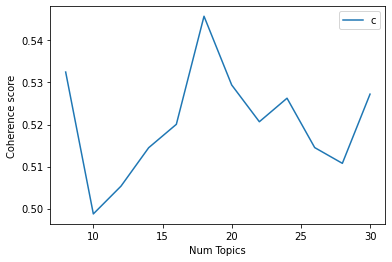

In [22]:
# Show graph
print(coherence_values)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
print(coherence_values)

[0.43157396307582285, 0.46263787110455074, 0.44300858554782263, 0.4471199758451803, 0.42981042058242697, 0.4447975748186329, 0.4373850803489953, 0.4483284603157475, 0.43000401484674317, 0.4284624813494124, 0.4342444364948314, 0.4366804641021528]


In [65]:
optimal_model, coherence = mallet_LDA(corpus=mix, num_topics=18)
print(optimal_model)

[(4,
  [('agricultur', 0.03001758352172821),
   ('farm', 0.02913840743531776),
   ('farmer', 0.025056518462697814),
   ('technolog', 0.017646320020095453),
   ('adopt', 0.015008791760864105),
   ('urban', 0.014318010550113038),
   ('product', 0.012559658377292138),
   ('impact', 0.011366490831449385),
   ('improv', 0.009356945491082642),
   ('food', 0.00916855061542326)]),
 (12,
  [('crop', 0.05464666349874415),
   ('field', 0.02701785350621139),
   ('data', 0.026882085398139976),
   ('map', 0.024506143506890232),
   ('area', 0.015952752698391148),
   ('yield', 0.015070259995926956),
   ('remot_sen', 0.012694318104677211),
   ('inform', 0.012151245672391555),
   ('base', 0.010725680537641709),
   ('land', 0.00930011540289186)]),
 (14,
  [('hundr_and', 0.025518008621888473),
   ('one_hundr', 0.022736754276178557),
   ('two_thousand', 0.02197190933110833),
   ('thousand_,', 0.02169378389653734),
   ('cow', 0.017243776943401474),
   ('one_thousand', 0.014879710749548046),
   ('twenti', 0.

In [66]:
corpus = mix
preprocess_abstract = preprocess_corpus(corpus)
bigrams = make_bigrams(preprocess_abstract)

# Create Dictionary
id2word = gensim.corpora.Dictionary(bigrams)

# Create Corpus
texts = bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=18, id2word=id2word)


def format_topics_sentences(ldamodel, corpus, texts = bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.0960,"crop, field, data, map, area, yield, remot_sen...","[introduct, field, base, phenotyp, promis, gat..."
1,1,5.0,0.4847,"plant, improv, perform, design, gener, researc...","[high, perform, comput, hpc, applic, essenti, ..."
2,2,0.0,0.1217,"product, agricultur, develop, technolog, proce...","[introduct, appl, one, import, fruit, world, c..."
3,3,12.0,0.1414,"crop, field, data, map, area, yield, remot_sen...","[introduct, potato, crop, solarium, tuberosum,..."
4,4,17.0,0.1046,"de, thousand_and, highlight, le, univers, la, ...","[introduct, two_thousand, and_seventeen, peach..."
5,5,0.0,0.1217,"product, agricultur, develop, technolog, proce...","[introduct, rapid, popul_growth, develop_count..."
6,6,15.0,0.1061,"system, base, estim, oper, sensor, uav, cluste...","[introduct, unman_aircraft, system, uass, disc..."
7,7,12.0,0.4106,"crop, field, data, map, area, yield, remot_sen...","[recent_year, unman_aerial, system_ua, emerg, ..."
8,8,7.0,0.5307,"water, irrig, increas, paramet, valu, manag, l...","[oil_palm, industri, vital, malaysian, economi..."
9,9,9.0,0.4498,"model, predict, machin_learn, variabl, algorit...","[compar, differ, analyt, method, explain, crop..."


In [67]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

    
Document_No = list(sent_topics_sorteddf_mallet.index)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

#keep Document_No
sent_topics_sorteddf_mallet["Document_No"] = Document_No

# Show
sent_topics_sorteddf_mallet.head(40)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Document_No
0,0.0,0.8543,"product, agricultur, develop, technolog, proce...","[actual, import, research, theme, combat, hung...",1347
1,1.0,0.7822,"practic, studi, function, soil, level, health,...","[одной, из, основных, тенденций, изменения, су...",1525
2,2.0,0.6620,"data, applic, agricultur, technolog, farm, man...","[machinelearn, ml, offer, newapproach, analyz,...",1628
3,3.0,0.8073,"dan, yang, dengan, one_hundr, °c, twenti, pada...","[pengembangan, pangan, fungsion, berbasi, baha...",1107
4,4.0,0.6326,"agricultur, farm, farmer, technolog, adopt, ur...","[agricultur_sector, nigeria, character, low, p...",1191
5,5.0,0.6141,"plant, improv, perform, design, gener, researc...","[keyword_comput, vision, semant_segment, synth...",1463
6,6.0,0.5789,"system, farm, pig, monitor, base, measur, anim...","[behavior, livestock_farm, primari, repres, an...",2005
7,7.0,0.5330,"water, irrig, increas, paramet, valu, manag, l...","[oil_palm, industri, vital, malaysian, economi...",119
8,8.0,0.6236,"detect, imag, method, algorithm, fruit, segmen...","[acquisit, qualiti, inform, plug_seedl, founda...",438
9,9.0,0.5090,"model, predict, machin_learn, variabl, algorit...","[wind_power, variabl, gener, resourc, therefor...",1746


In [72]:
for i in range (24):
    print("\n")
    print(sent_topics_sorteddf_mallet["Keywords"][i])
    print(mix[sent_topics_sorteddf_mallet["Document_No"][i]])



product, agricultur, develop, technolog, process, industri, energi, system, strategi, research
Actual importance of research theme: Combating hunger and providing the Earth’s population with sufficient amount of products is considered one of the strategic priorities of human civilization sustainable development by the UN up to 2030. The rapid growth of this planet’s human population in the 21st century, estimated at 7.6. billion people, leads to the global demand for production and foodstuff. Simultaneously, traditional strategies of extensive development conventional in the 20th century and “target” intensification of agriculture do not take expected positive effect nowadays. World economy requires for new strategies of agricultural production, as well as promoting ‘green revolution’ based on the ground of IT technology advances and “Industry 4.0.”. The generalization of world experience concerning development and implementing agricultural production strategies in the 21st century i

KeyError: 18